# <span style="color:black"> Data Science Salaries </span>
Please see the corresponding [kaggle](https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023?select=ds_salaries.csv) link for the details.

# <span style="color:green"> DATA </span>

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import pandas as pd
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})

import pycountry
import seaborn as sns

In [42]:
data = pd.read_csv("ds_salaries.csv")
data.head(4)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M


# <span style="color:green"> DATA ANALYSIS </span>

In [43]:
print(f"total data shape: {data.shape}")

max_salary_index = np.argmax(data.loc[:,'salary_in_usd'])
print(f"The highest paid data scientist made {data.loc[max_salary_index,'salary_in_usd']} US dollars,\n\
in {data.loc[max_salary_index,'work_year']}, \
works in {data.loc[max_salary_index,'employee_residence']}, \
and has an experience level {data.loc[max_salary_index,'experience_level']}.")

def unique_features(data):
    nums = []# unique possibilities for each feature
    for feature in data.columns:
        num = len(data.loc[:,feature].unique())
        nums.append(num)
        print(f"feature {feature:20s}: unique values = {num}")
        
unique_features(data)

total data shape: (3755, 11)
The highest paid data scientist made 450000 US dollars,
in 2020, works in US, and has an experience level MI.
feature work_year           : unique values = 4
feature experience_level    : unique values = 4
feature employment_type     : unique values = 4
feature job_title           : unique values = 93
feature salary              : unique values = 815
feature salary_currency     : unique values = 20
feature salary_in_usd       : unique values = 1035
feature employee_residence  : unique values = 78
feature remote_ratio        : unique values = 3
feature company_location    : unique values = 72
feature company_size        : unique values = 3


## Converting some of the categorical data to numerical data
We do this for those features that can be intrepreted as a numrical feature (i.e., can be quantified), such as the experience level.

In [44]:
def experience_level_to_num(experience_level):
    if experience_level == 'EN':
        return 0
    elif experience_level == 'MI':
        return 1
    elif experience_level == 'SE':
        return 2
    elif experience_level == 'EX':
        return 3


data['experience_level'] = data['experience_level'].apply(experience_level_to_num) #replace({'EN':0,'MI':1,'SE':2,'EX':3})

def employment_type_to_num(employment_type):
    if employment_type == 'FL':
        return 0
    elif employment_type == 'CT':
        return 1
    elif employment_type == 'PT':
        return 2
    elif employment_type == 'FT':
        return 3
    
data['employment_type'] = data['employment_type'].apply(employment_type_to_num)

def company_size_to_num(company_size):
    if company_size == 'S':
        return 0
    elif company_size == 'M':
        return 1
    elif company_size == 'L':
        return 2
    
data['company_size'] = data['company_size'].apply(company_size_to_num)

def work_year_to_num(work_year):
    if work_year == 2020:
        return 0
    elif work_year == 2021:
        return 1
    elif work_year == 2022:
        return 2
    elif work_year == 2023:
        return 3
    
data['work_year'] = data['work_year'].apply(work_year_to_num)

def remote_ratio_to_num(remote_ratio):
    if remote_ratio == 0:
        return 0
    elif remote_ratio == 50:
        return 0.5
    elif remote_ratio == 100:
        return 1
    
data['remote_ratio'] = data['remote_ratio'].apply(remote_ratio_to_num)


data = data.drop(columns=['salary','salary_currency']) # keep only salary in US dollars

data.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,3,2,3,Principal Data Scientist,85847,ES,1.0,ES,2
1,3,1,1,ML Engineer,30000,US,1.0,US,0
2,3,1,1,ML Engineer,25500,US,1.0,US,0
3,3,2,3,Data Scientist,175000,CA,1.0,CA,1
4,3,2,3,Data Scientist,120000,CA,1.0,CA,1


## Grouping the categorical data
Here, we group similar categories under more broad labels.

- **job title:** group the job titles under categories data_scientist, engineer, researcher, AI developer, and manager.

In [45]:
data.value_counts('job_title')

job_title
Data Engineer                1040
Data Scientist                840
Data Analyst                  612
Machine Learning Engineer     289
Analytics Engineer            103
                             ... 
Compliance Data Analyst         1
Cloud Data Architect            1
BI Data Engineer                1
Azure Data Engineer             1
Staff Data Scientist            1
Length: 93, dtype: int64

In [46]:
data_scientist_titles = ['Data Scientist','Data Analyst','Data Modeler','Data Strategist',\
                         'Data Quality Analyst','Compliance Data Analyst','Data Architect',\
                         'Business Data Analyst','Applied Data Scientist','Staff Data Analyst',\
                         'Data Specialist','Financial Data Analyst','BI Developer','BI Analyst',\
                         'Data Science Consultant','Data Analytics Specialist','BI Data Analyst',\
                         'Insight Analyst','Big Data Architect' ,'Product Data Analyst',\
                         'Data Analytics Consultant','Data Management Specialist','Data Operations Analyst',\
                         'Marketing Data Analyst','Power BI Developer','Product Data Scientist',\
                         'Cloud Data Architect','Staff Data Scientist','Finance Data Analyst']
engineer_titles = ['ML Engineer','Research Engineer','Analytics Engineer','Business Intelligence Engineer',\
                   'Machine Learning Engineer','Data Engineer','Computer Vision Engineer',\
                   'Applied Machine Learning Engineer','ETL Engineer','Data DevOps Engineer',\
                   'Big Data Engineer','BI Data Engineer','MLOps Engineer','Autonomous Vehicle Technician',\
                   'Cloud Database Engineer','Data Infrastructure Engineer','Software Data Engineer',\
                   'Data Operations Engineer','Machine Learning Infrastructure Engineer','Deep Learning Engineer',\
                   'Machine Learning Software Engineer','Computer Vision Software Engineer','Azure Data Engineer',\
                   'Marketing Data Engineer','Data Science Engineer','Machine Learning Research Engineer',\
                   'NLP Engineer','Data Analytics Engineer','Cloud Data Engineer','ETL Developer']
researcher_titles = ['Applied Scientist','Research Scientist','Machine Learning Researcher',\
                  'Machine Learning Scientist','Applied Machine Learning Scientist','Deep Learning Researcher',\
                  'Machine Learning Developer','3D Computer Vision Researcher']
manager_titles = ['Principal Data Scientist','Data Analytics Manager','Head of Data','Data Science Manager',\
                  'Data Manager','Lead Data Analyst','Director of Data Science','Lead Data Scientist',\
                  'Data Science Lead','Head of Data Science','Data Analytics Lead','Data Lead',\
                  'Manager Data Management','Principal Machine Learning Engineer','Data Science Tech Lead',\
                  'Data Scientist Lead','Principal Data Architect','Machine Learning Manager',\
                  'Lead Machine Learning Engineer','Lead Data Engineer','Head of Machine Learning',\
                  'Principal Data Analyst','Principal Data Engineer']
AI_titles = ['AI Developer','AI Scientist','AI Programmer']

# a function to replace job_title feature names
def group_job_title(job_title):
    if job_title in data_scientist_titles:
        return "data scientist"
    elif job_title in engineer_titles:
        return "engineer"
    elif job_title in researcher_titles:
        return "researcher"
    elif job_title in manager_titles:
        return "manager"
    elif job_title in AI_titles:
        return "AI developer"

In [47]:
data['job_category'] = data['job_title'].apply(group_job_title)

In [48]:
data.value_counts('job_category')

job_category
data scientist    1694
engineer          1640
manager            196
researcher         196
AI developer        29
dtype: int64

- **company and employee location:** group countaries into bigger regions. We first use pycountry to convert country codes to country names to faciliate the process.

In [49]:
def country_name(country_code):
    try:
        return pycountry.countries.get(alpha_2=country_code).name
    except:
        return 'other'
    
data['company_country'] = data['company_location'].apply(country_name)
data['employee_country'] = data['employee_residence'].apply(country_name)

In [50]:
data.value_counts('company_country')

company_country
United States           3040
United Kingdom           172
Canada                    87
Spain                     77
India                     58
                        ... 
Malaysia                   1
Malta                      1
Moldova, Republic of       1
Morocco                    1
Viet Nam                   1
Length: 72, dtype: int64

In [51]:
salary_by_country = data.groupby('company_country', as_index=False)['salary_in_usd'].mean()

fig = px.choropleth(salary_by_country,locations='company_country',locationmode='country names',color='salary_in_usd',
                    color_continuous_scale='jet',projection='natural earth',hover_name='company_country',
                    labels={'salary_in_usd':'Average Salary in USD'},title='Distribution of average salary by company location')


# fig.show()
fig.write_image("choropleth_plot.png")

![Choropleth Plot](choropleth_plot.png)

In [52]:
russia = ['Russian Federation']
europe = ['Spain','Germany','United Kingdom','Netherlands',\
          'Switzerland','France','Finland','Ukraine','Ireland',\
          'Sweden','Slovenia','Portugal','Croatia','Estonia',\
          'Armenia','Bosnia and Herzegovina','Greece','North Macedonia',
          'Latvia','Romania','Italy','Poland','Albania','Lithuania',\
          'Hungary','Austria','Slovakia','Czechia','Turkey','Denmark',\
          'Belgium','Luxembourg','Moldova, Republic of',\
          'Malta','Cyprus','Bulgaria','Serbia','Jersey']
united_states = ['United States']
america_north = ['Canada','Mexico']
america_rest = ['Colombia','Brazil','Argentina','Costa Rica','Bahamas','Puerto Rico',\
                'Bolivia, Plurinational State of','Honduras','Chile','Dominican Republic']
africa = ['Nigeria','Central African Republic','Ghana','Kenya','Morocco','Egypt','Algeria','Tunisia']
asia_east = ['Japan','China']
asia_middle = ['United Arab Emirates','Iran, Islamic Republic of','Iraq','Kuwait']
asia_rest = ['Hong Kong','Singapore','Thailand','Viet Nam','Philippines',\
             'Indonesia','India','Pakistan','Malaysia','Uzbekistan']
israel = ['Israel']
oceania = ['Australia','New Zealand','American Samoa']

# a function to replace country feature names
def group_country(country):
    if country in united_states:
        return "US"
    elif country in russia:
          return "russia"
    elif country in europe:
        return "europe"
    elif country in america_north:
        return "america_north"
    elif country in america_rest:
        return "america_rest"
    elif country in asia_east:
        return "asia_east"
    elif country in asia_middle:
        return "asia_middle"
    elif country in asia_rest:
          return "asia_rest"
    elif country in israel:
          return "israel"
    elif country in africa:
        return "africa"
    elif country in oceania:
        return "oceanoia"

In [53]:
data['company_continent'] = data['company_country'].apply(group_country)
data['employee_continent'] = data['employee_country'].apply(group_country)

In [54]:
dataCleaned = data.drop(columns=['job_title','employee_residence','employee_country','company_location','company_country'])

## Display and analyze the finalized table of data

In [55]:
unique_features(dataCleaned)
dataCleaned.head(4)

feature work_year           : unique values = 4
feature experience_level    : unique values = 4
feature employment_type     : unique values = 4
feature salary_in_usd       : unique values = 1035
feature remote_ratio        : unique values = 3
feature company_size        : unique values = 3
feature job_category        : unique values = 5
feature company_continent   : unique values = 11
feature employee_continent  : unique values = 11


,work_year,experience_level,employment_type,salary_in_usd,remote_ratio,company_size,job_category,company_continent,employee_continent
0,3,2,3,85847,1.0,2,manager,europe,europe
1,3,1,1,30000,1.0,0,engineer,US,US
2,3,1,1,25500,1.0,0,engineer,US,US
3,3,2,3,175000,1.0,1,data scientist,america_north,america_north


## One-hot encoding

In [56]:
cat_features = ['job_category','company_continent','employee_continent']
print(f"The multiclass categorical features are:\n{cat_features}")
dataOHE = pd.get_dummies(data = dataCleaned, prefix = cat_features, columns = cat_features)

features = [x for x in dataOHE.columns if x != 'salary_in_usd'] ## Removing our target variable
print(f"total number of features after one-hot encoding: {len(features)}")

The multiclass categorical features are:
['job_category', 'company_continent', 'employee_continent']
total number of features after one-hot encoding: 32


## Correllation

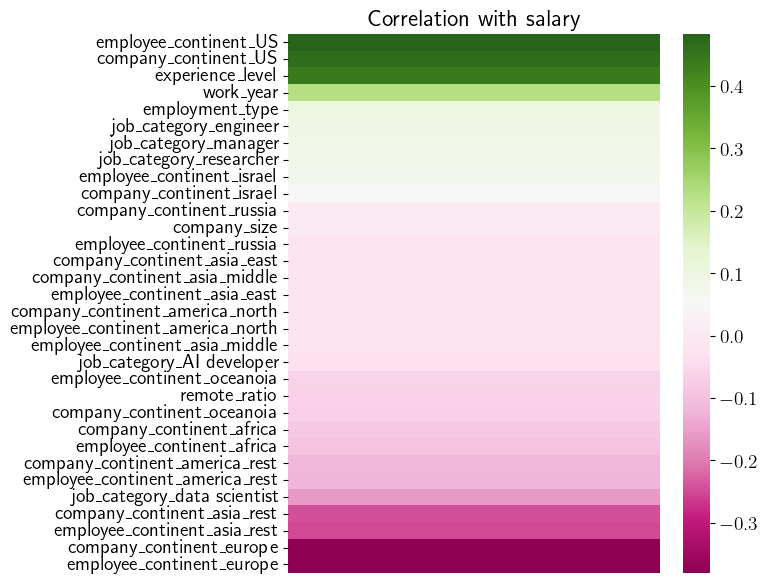

In [57]:
corr = dataOHE.corr().loc[:,'salary_in_usd']
corr = corr.sort_values(ascending=False)

plt.figure(figsize=(6,7))
sns.heatmap(corr.iloc[1:].to_frame(), cmap="PiYG", xticklabels=False, yticklabels=True)
plt.title('Correlation with salary')
plt.show()

# <span style="color:green"> MACHINE LEARNING </span>

## Split the data using Scikit-learn

In [58]:
X_train, X_dev, y_train, y_dev = train_test_split(dataOHE[features],dataOHE['salary_in_usd'],train_size=0.8, random_state=1)

X_train = X_train.to_numpy()
X_dev   = X_dev.to_numpy()

y_train = y_train.to_numpy().reshape((-1,1))
y_dev   = y_dev.to_numpy().reshape((-1,1))

print(f"X_train.shape = {X_train.shape}, X_dev.shape = {X_dev.shape}")
print(f"y_train.shape = {y_train.shape}, y_dev.shape = {y_dev.shape}")

X_train.shape = (3004, 32), X_dev.shape = (751, 32)
y_train.shape = (3004, 1), y_dev.shape = (751, 1)


## Normalize the traget data

In [59]:
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(y_train)

# <span style="color:blue"> Neural Netwrok </span>

## Architecture

In [60]:
num_features = len(features)
modelNN = Sequential([
    tf.keras.Input(shape=(num_features,)),
    Dense(units=64, activation='relu'  , name='L1'),
    Dense(units=32, activation='relu'  , name='L2'),
    Dense(units=16, activation='relu'  , name='L3'),
    Dense(units=8 , activation='relu'  , name='L4'),
    Dense(units=1 , activation='linear', name='LO')
])
modelNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 64)                2112      
                                                                 
 L2 (Dense)                  (None, 32)                2080      
                                                                 
 L3 (Dense)                  (None, 16)                528       
                                                                 
 L4 (Dense)                  (None, 8)                 136       
                                                                 
 LO (Dense)                  (None, 1)                 9         
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [61]:
modelNN.compile(loss=tf.keras.losses.MeanSquaredError(),optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
modelNN.fit(X_train,norm_l(y_train),epochs=100,verbose=0)
trainErr_NN = 0.5*mean_squared_error(norm_l(y_train),modelNN.predict(X_train,verbose=0))
devErr_NN = 0.5*mean_squared_error(norm_l(y_dev),modelNN.predict(X_dev,verbose=0))
print(f"Neural Network:\n train error = {trainErr_NN:.4f}, dev error = {devErr_NN:.4f}")

Neural Network:
 train error = 0.2616, dev error = 0.3611


# <span style="color:blue"> Regression </span>

In [62]:
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(X_train,norm_l(y_train))
trainErr_regr = 0.5*mean_squared_error(norm_l(y_train),regr.predict(X_train))
devErr_regr = 0.5*mean_squared_error(norm_l(y_dev),regr.predict(X_dev))
print(f"Regression:\n train error = {trainErr_regr:.4f}, dev error = {devErr_regr:.4f}")

Regression:
 train error = 0.3145, dev error = 0.3645


# <span style="color:blue"> XGBoost </span>

In [63]:
n_estimators = 100
early_stopping_rounds = 20
learning_rate = 0.1
max_depth = 6
lambda_ = 0
modelXGB = XGBRegressor(n_estimators = n_estimators, learning_rate = learning_rate,
                      verbosity = 0, random_state = 1, max_depth = max_depth,alpha=lambda_)
modelXGB.fit(X_train,norm_l(y_train),verbose=False)

trainErr_XGBoost = 0.5*mean_squared_error(norm_l(y_train),modelXGB.predict(X_train))
devErr_XGBoost = 0.5*mean_squared_error(norm_l(y_dev),modelXGB.predict(X_dev))
print(f"XGBoost:\n train error = {trainErr_XGBoost:.4f}, dev error = {devErr_XGBoost:.4f}")

XGBoost:
 train error = 0.2574, dev error = 0.3274


# <span style="color:green"> BEST MODEL </span> 

## Notes:
- Regularization did not help much in decreasing the overfitting.
- Changing the max depth in XGBoost didn't seem to have much of an impct either.
- None of the above models work well, as we will see below! Perhaps we could drop the features with low correlation to get better results. While all three models predict similar values, their predictions are sometimes quite different from the actual values.

In [64]:
errs = [[trainErr_NN,devErr_NN],[trainErr_regr,devErr_regr],[trainErr_XGBoost,devErr_XGBoost]]
errsdf = pd.DataFrame(errs,columns=['train MSE','dev MSE'],index=['Neural Network','Regression','XGBoost'])
errsdf

,train MSE,dev MSE
Neural Network,0.261576,0.361130
Regression,0.314470,0.364531
XGBoost,0.257357,0.327438


## Testing specific examples
Here we see how our models can predict the salary.

In [76]:
n = len(X_dev)
samples = np.random.randint(n,size=(5,))

# Use keras to de-normalize the predcited target values
norm_l_revert = tf.keras.layers.Normalization(axis=-1, invert=True)
norm_l_revert.adapt(y_train)

X_test = X_dev[samples,:]

salary_data = y_dev[samples,0]
salary_NN = norm_l_revert(modelNN.predict(X_test,verbose=0).reshape((-1,))).numpy()[0]
salary_regr = norm_l_revert(regr.predict(X_test).reshape((-1,))).numpy()[0]
salary_XGB = norm_l_revert(modelXGB.predict(X_test)).numpy()[0]

errs_test = np.c_[salary_data.T,salary_NN.T,salary_regr.T,salary_XGB.T]
pd.options.display.float_format = '{:.2f}'.format
errs_test_df = pd.DataFrame(errs_test,columns=['data','Neural Netwrok','Regression','XGBoost'])
errs_test_df

,data,Neural Netwrok,Regression,XGBoost
0,129300.00,166362.84,166326.92,166572.34
1,222200.00,210573.50,197300.42,204989.73
2,140000.00,149642.55,148136.12,146175.97
3,170000.00,170056.66,168047.67,168632.03
4,144000.00,149642.55,148136.12,146175.97
